# Učitavanje biblioteka

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter

# Analiza podataka

In [23]:
df = pd.read_csv('datasets/yield_df.csv')
df.info()
df.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


Unnamed: 0                       False
Area                             False
Item                             False
Year                             False
hg/ha_yield                      False
average_rain_fall_mm_per_year    False
pesticides_tonnes                False
avg_temp                         False
dtype: bool

Dataset nema duplikata ni nedostajućih vrednosti

# Opis parametara

- Area: Država u kojoj je usev posađen.
- Item: Tip useva koji je posađen.
- Year: Godina sađenja.
- hg/ha_yield: Količina useva koja je posađenja.
- average_rain_fall_mm_per_year: Količina kišnice.
- pesticides_tonnes: Količina pesticida u tonima.
- avg_temp: Prosečna temperatura u toku godine.
    

Preprocesurianje podataka se svodi na nekoliko koraka:

1. Kodiranje string vrednosti. (LabelEncoding)
2. Skaliranje podataka.
3. Split podataka na trening i test set.

,Area,Item,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,1,36613,1485.0,121.0,16.37
1,0,2,66667,1485.0,121.0,16.37
2,0,3,23333,1485.0,121.0,16.37
3,0,4,12500,1485.0,121.0,16.37
4,0,5,7000,1485.0,121.0,16.37


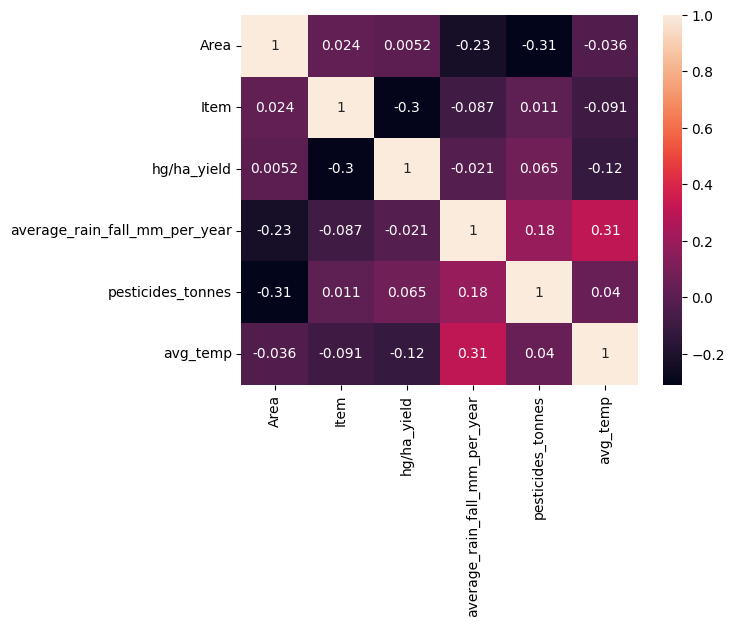

In [24]:
#Import the dataset
df = df.drop(columns=['Year','Unnamed: 0'])

# Remove mintority 'Item' classes
df = df[df['Item'] != 'Yams']
df = df[df['Item'] != 'Plantains and others']

#Label encode string columns
label_encoder = LabelEncoder()

df['Area'] = label_encoder.fit_transform(df['Area'])
df['Item'] = label_encoder.fit_transform(df['Item'])

correlation=df.corr()
sb.heatmap(correlation,annot=True)

df.head()

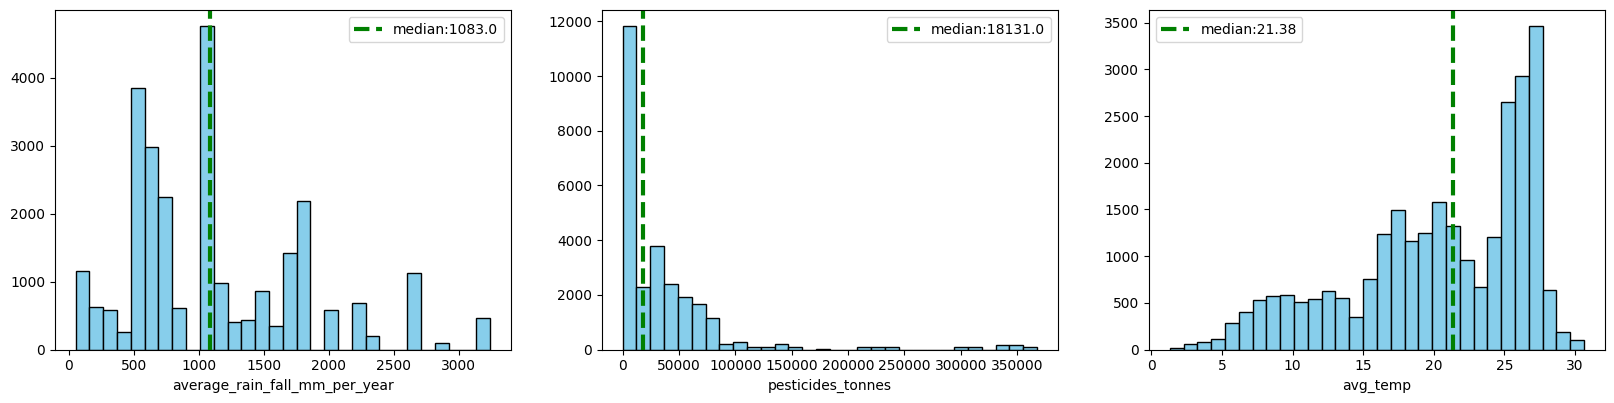

In [35]:
plt.figure(figsize=(20,15))

for ind,col in enumerate(df[['average_rain_fall_mm_per_year','pesticides_tonnes','avg_temp']]):
    plt.subplot(3,3,ind+1)
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.axvline(np.round(df[col].median(),2), color='g', linestyle='dashed', linewidth=3)
    plt.xlabel(col)
    plt.legend([f'median:{np.round(df[col].median(),2)}'])
plt.show()

In [36]:
#Izdvajanje ekstrema
for col in df[['average_rain_fall_mm_per_year','pesticides_tonnes','avg_temp']]:
    Q1=np.quantile(df[col],0.25)
    Q3=np.quantile(df[col],0.75)
    IQR=Q3-Q1
    low_lim=Q1-IQR*1.5
    up_lim=Q3+IQR*1.5
    df=df[(df[col]>=low_lim)&(df[col]<=up_lim)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25459 entries, 0 to 28241
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           25459 non-null  int64  
 1   Item                           25459 non-null  int64  
 2   hg/ha_yield                    25459 non-null  int64  
 3   average_rain_fall_mm_per_year  25459 non-null  float64
 4   pesticides_tonnes              25459 non-null  float64
 5   avg_temp                       25459 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 1.4 MB


In [37]:
# Splitting data into features and target
y = df['hg/ha_yield']
X_orig = df.drop(columns=['hg/ha_yield'])

# Scalling the data
scaler = StandardScaler()
X = scaler.fit_transform(X_orig,y)

#Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.37, random_state=37)

# Treniranje razlicitih modela

Treniranje je rađeno sa nekoliko različitih regresionih algoritama. Pre svega je uzeta linearna regresija (Nije efikasana, uzeta kao kontrolni algoritam). Ručnom analizom podataka je ustanovljena jasna korelacija između tipa useva i količine, samim tim za rad su uzeti algoritmi: 

- DecisionTreeRegressor
- RandomForestRegressor
- Bernoulli Naive Bayes

Algoritmi su dali visok procenat uspešnosti, mada bojaznost od overfitting-a postoji zbog prirode algoritama i zbog samog dataset-a.

Preciznost algoritma može se videti kroz score u odnosu na test set podataka ili vizuelno kroz historgram vrednosti razlike (residual). (što više vrednosti cirkuliše oko 0, algoritam je precizniji, nedostatak distribucije može da ukaže na overfitting)

13.021120258640817


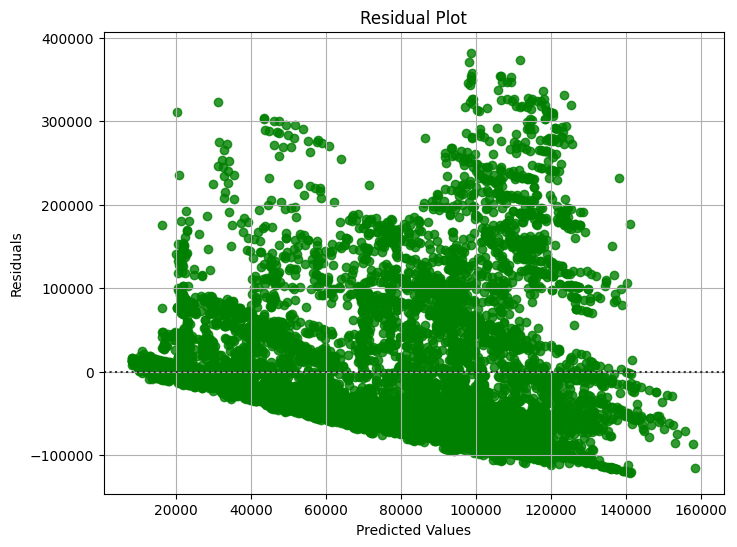

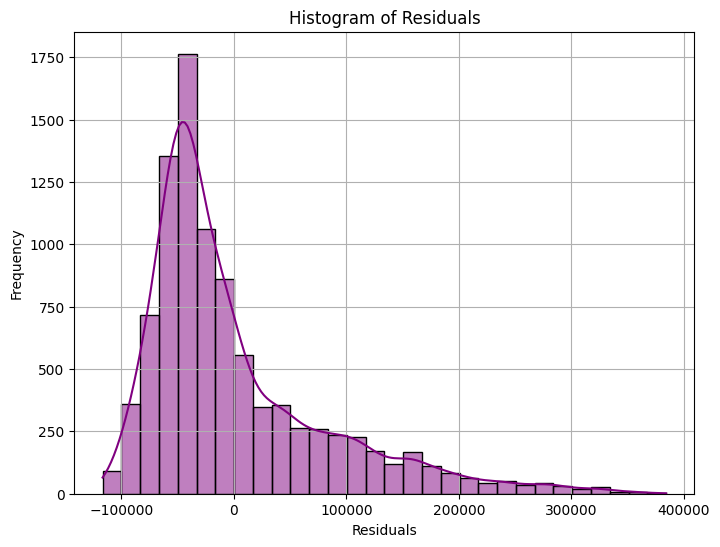

In [39]:
#Linear regression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
lr_score = lr_model.score(X_test,y_test)
print(lr_score * 100)

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sb.residplot(x=y_pred, y=residuals, color='green', line_kws={'color': 'red'})
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sb.histplot(residuals, bins=30, kde=True, color='purple', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

95.60820516077433


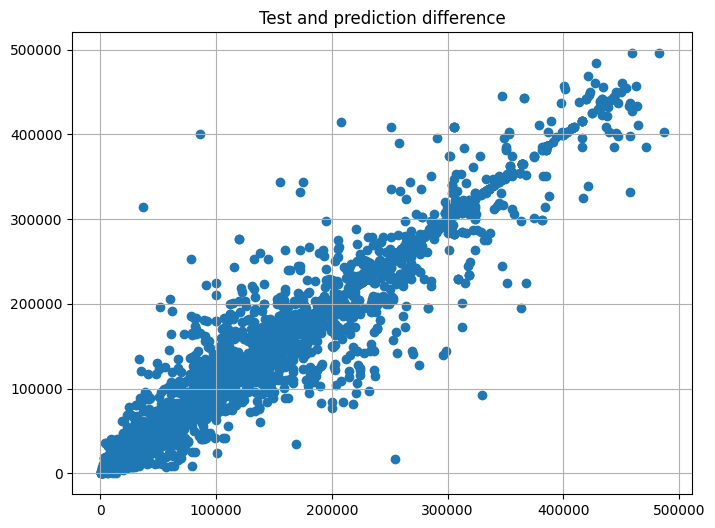

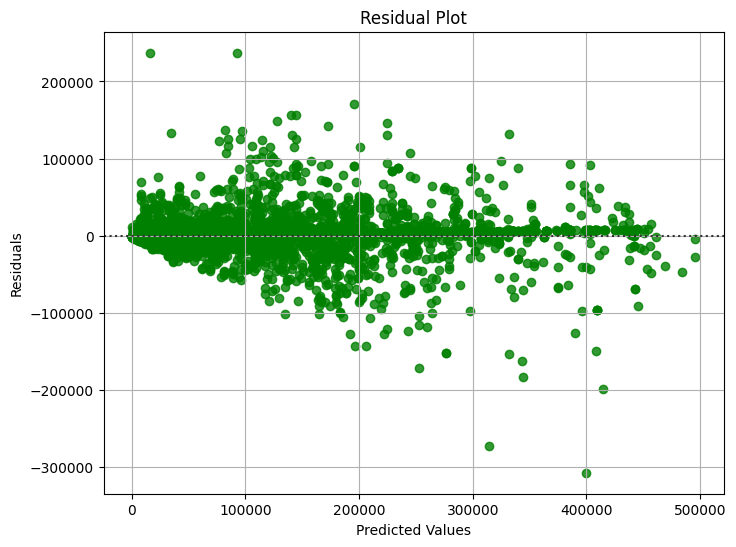

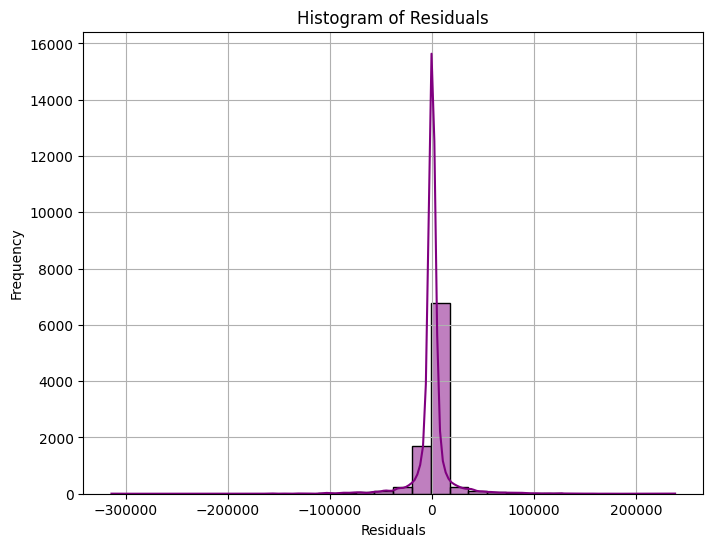

In [41]:
#Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor

#Only hyperparameter set is the function tthat measures the quality of a split.
dtr_model = DecisionTreeRegressor(criterion='friedman_mse')

dtr_model.fit(X_train,y_train)
y_pred = dtr_model.predict(X_test)

dtr_score = dtr_model.score(X_test,y_test)
print(dtr_score * 100)

plt.figure(figsize=(8, 6))
plt.title("Test and prediction difference")
plt.scatter(y_test,y_pred)
plt.grid(True)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sb.residplot(x=y_pred, y=residuals, color='green', line_kws={'color': 'red'})
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sb.histplot(residuals, bins=30, kde=True, color='purple', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

97.33540248712632


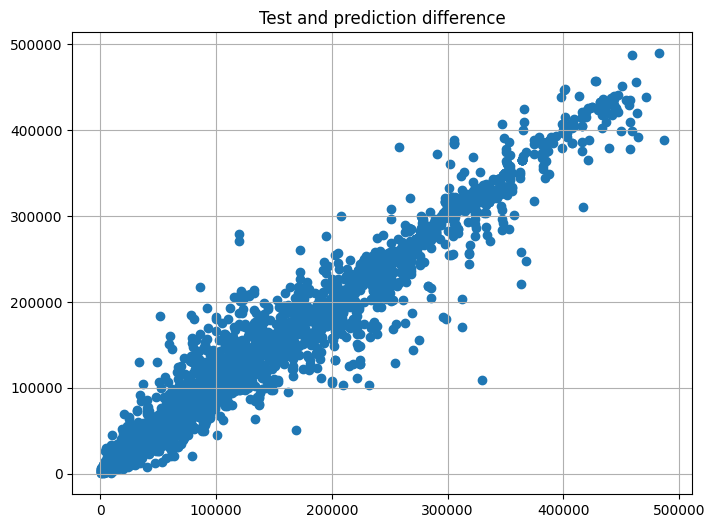

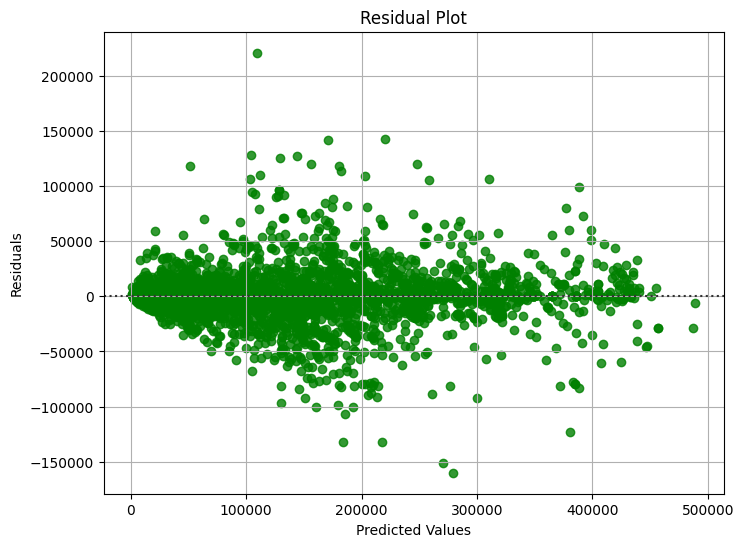

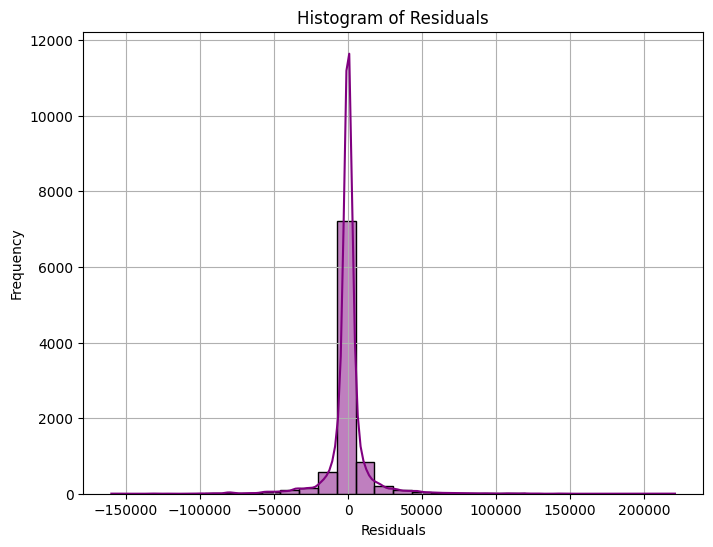

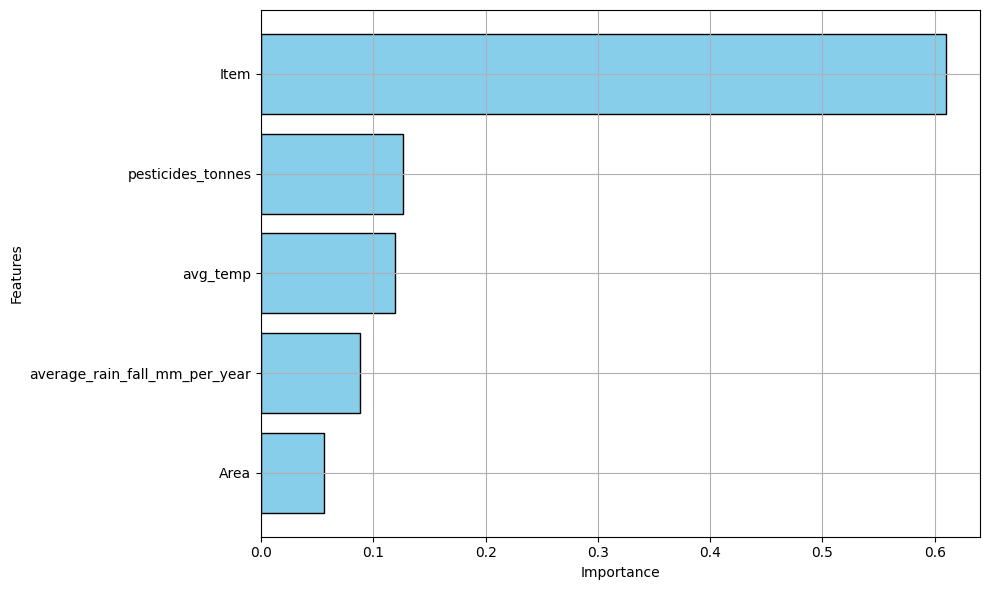

In [42]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rf_score = rf_model.score(X_test,y_test) * 100

print(rf_score)

plt.figure(figsize=(8, 6))
plt.title("Test and prediction difference")
plt.scatter(y_test,y_pred)
plt.grid(True)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sb.residplot(x=y_pred, y=residuals, color='green', line_kws={'color': 'red'})
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sb.histplot(residuals, bins=30, kde=True, color='purple', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)
sorted_features = [X_orig.columns[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], color="skyblue", edgecolor="black")
plt.yticks(range(len(feature_importances)), sorted_features)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

97.33540248712632


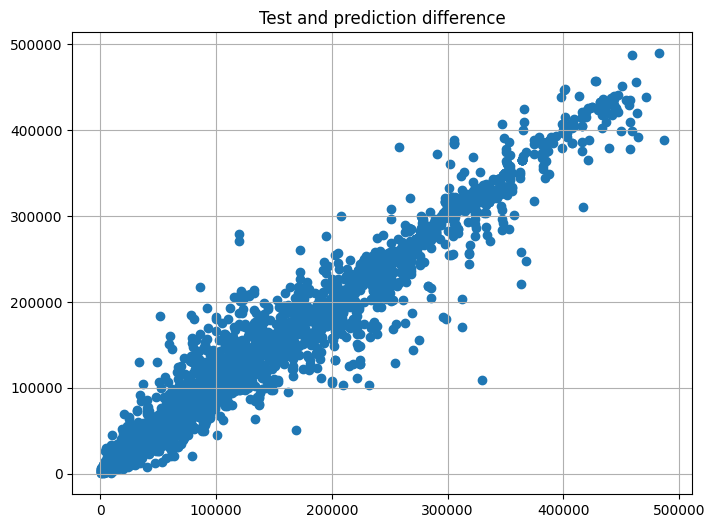

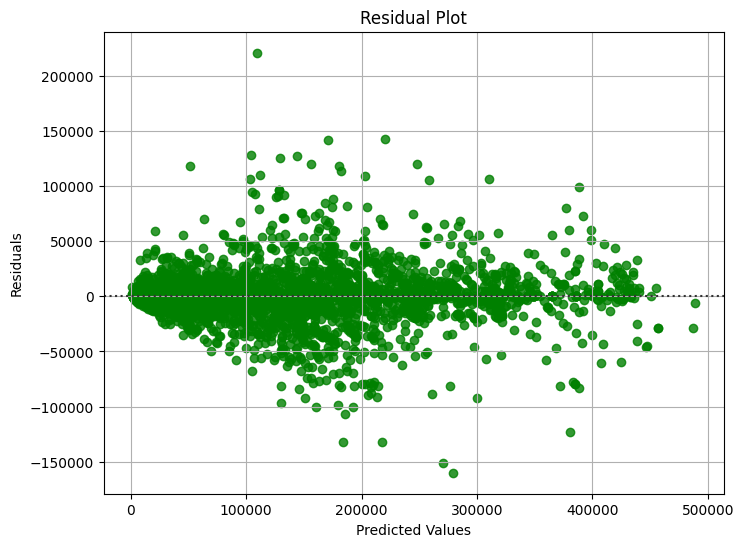

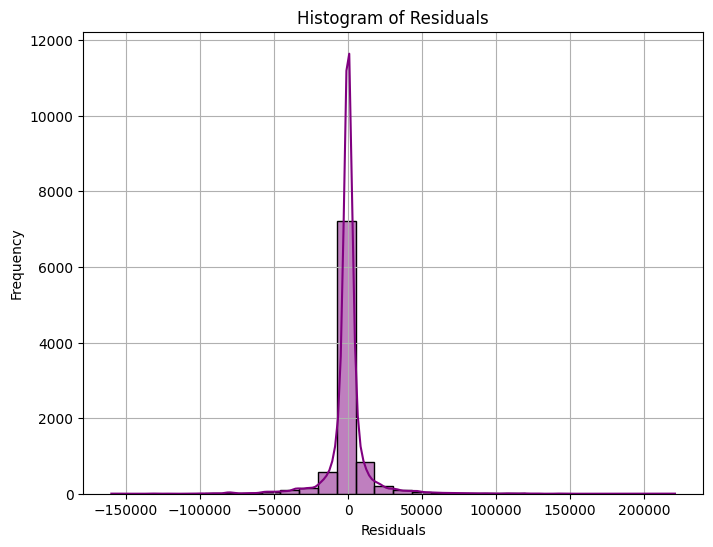

In [44]:
# Naive Bayes 
from sklearn.naive_bayes import BernoulliNB

nb_model = BernoulliNB()

nb_model.fit(X_train,y_train)

y_pred = rf_model.predict(X_test)
nb_score = rf_model.score(X_test,y_test) * 100

print(nb_score)

plt.figure(figsize=(8, 6))
plt.title("Test and prediction difference")
plt.scatter(y_test,y_pred)
plt.grid(True)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sb.residplot(x=y_pred, y=residuals, color='green', line_kws={'color': 'red'})
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sb.histplot(residuals, bins=30, kde=True, color='purple', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()